# Variogram calculation

Script adapted from: https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Variogram.ipynb


## Load the required libraries

In [186]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geopandas as gpd


## Declare functions

In [187]:
# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    import os
    import numpy as np  
    import pandas as pd

    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# utility to convert pandas DataFrame to a GSLIB Geo-EAS file for use with GSLIB methods
def Dataframe2GSLIB(data_file,df):
    colArray = []
    colArray = df.columns
    ncol = len(df.columns) 
    nrow = len(df.index)
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write(str(ncol) + '\n') 
    for icol in range(0, ncol): 
        file_out.write(df.columns[icol]  + '\n')  
    
    for irow in range(0, nrow):
        for icol in range(0, ncol):
            file_out.write(str(df.iloc[irow,icol])+ ' ')  
        file_out.write('\n')

    file_out.close()       

# utility to convert GSLIB Geo-EAS files to a numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny):
    import os
    import numpy as np  

    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)
        
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]
        for iy in range(0,ny):
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ny-1-iy][ix] = head[0].split()[kcol]
    return array,col_name

# utility to convert numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods   
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()
    
# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')    
    plt.show()
    return
   
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

def vargplt(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    if vtype==0:
        im = plt.scatter(lag,gamma,s=None, c=npair, marker=None, label = name,cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    else:
        plt.plot(lag,gamma,'C3',lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im

def vargplts(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    nvar = lags.shape[0]
    for ivar in range(0, nvar):
        if vtype[ivar]==0:
            im = plt.scatter(lag[ivar],gamma[ivar],s=None,label = name[ivar],c=npair[ivar], marker=marker[ivar], cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
        else:
            plt.plot(lag[ivar],gamma[ivar], 'C3', lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im

# pixelplt with location map superimposed, reimplementation in Python of a MOD from GSLIB with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step)) 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.xlim(xmin,xmax-step)
    plt.ylim(ymin+step,ymax) 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return cs

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            

# normal score transform, wrapper for nscore from GSLIB (.exe must be in working directory)(not used in this demo)   
def nscore(x):
    import os
    import numpy as np
    file = 'nscore_out.dat'
    ndarray2GSLIB(x,"nscore.dat","value")
    
    file = open("nscore.par", "w")
    file.write("                  Parameters for NSCORE                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("nscore.dat           -file with data                                       \n")
    file.write("1   0                    -  columns for variable and weight                \n")
    file.write("-1.0e21   1.0e21         -  trimming limits                                \n")
    file.write("0                        -1=transform according to specified ref. dist.    \n")
    file.write("../histsmth/histsmth.out -  file with reference dist.                      \n")
    file.write("1   2                    -  columns for variable and weight                \n")
    file.write("nscore.out               -file for output                                  \n")
    file.write("nscore.trn               -file for output transformation table             \n")
    file.close()

    os.system('nscore.exe nscore.par')
    file_in = 'nscore.out'
    y,name = GSLIB2ndarray('nscore.out',1,nx,ny)
    return(y)

# cell-based declustering, 2D wrapper for declus from GSLIB (.exe must be in working directory)
def declus(df,xcol,ycol,vcol,cmin,cmax,cnum,bmin):
    import os
    import numpy as np
    nrow = len(df)
    weights = []
    file = 'declus_out.dat'
    file_out = open(file, "w")
    file_out.write('declus_out.dat' + '\n')  
    file_out.write('3' + '\n')  
    file_out.write('x' + '\n') 
    file_out.write('y' + '\n')
    file_out.write('value' + '\n')  
    for irow in range(0, nrow):
        file_out.write(str(df.iloc[irow][xcol])+' '+str(df.iloc[irow][ycol])+' '+str(df.iloc[irow][vcol])+' \n')        
    file_out.close()
    
    file = open("declus.par", "w")
    file.write("                  Parameters for DECLUS                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("declus_out.dat           -file with data                                   \n")
    file.write("1   2   0   3               -  columns for X, Y, Z, and variable           \n")
    file.write("-1.0e21     1.0e21          -  trimming limits                             \n")
    file.write("declus.sum                  -file for summary output                       \n") 
    file.write("declus.out                  -file for output with data & weights           \n")
    file.write("1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)    \n") 
    file.write(str(bmin) + "                -0=look for minimum declustered mean (1=max)   \n") 
    file.write(str(cnum) + " " + str(cmin) + " " + str(cmax) + " -number of cell sizes, min size, max size      \n")
    file.write("5                           -number of origin offsets                      \n")
    file.close()
    
    os.system('declus.exe declus.par')
    df = GSLIB2Dataframe("declus.out")
    for irow in range(0, nrow):
        weights.append(df.iloc[irow,3])    

    return(weights)
 
# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gam_2d(array,nx,ny,hsiz,nlag,xlag,ylag,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    ndarray2GSLIB(array,"gam_out.dat","gam.dat")
    
    file = open("gam.par", "w")
    file.write("                  Parameters for GAM                                       \n")
    file.write("                  ******************                                       \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gam_out.dat           -file with data                                      \n")
    file.write("1   1   0             -   number of variables, column numbers              \n")
    file.write("-1.0e21     1.0e21    -   trimming limits                                  \n")
    file.write("gam.out               -file for variogram output                           \n")
    file.write("1                     -grid or realization number                          \n")
    file.write(str(nx) + " 0.0 " + str(hsiz) + "  -nx, xmn, xsiz                           \n")
    file.write(str(ny) + " 0.0 " + str(hsiz) + "  -ny, ymn, ysiz                           \n")
    file.write(" 1   0.5   1.0        -nz, zmn, zsiz                                       \n")
    file.write("1 " + str(nlag) + "   -number of directions, number of lags                \n")
    file.write(str(xlag) + " " + str(ylag) + " 0 -ixd(1),iyd(1),izd(1)                     \n")
    file.write("1                     -standardize sill? (0=no, 1=yes)                     \n")
    file.write("1                     -number of variograms                                \n")
    file.write("1   1   1             -tail variable, head variable, variogram type        \n") 
    file.close()
    
    os.system('gam.exe gam.par')
    reading = True
    with open("gam.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gamv_2d(df,xcol,ycol,vcol,nlag,lagdist,azi,atol,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':df[vcol]})
    Dataframe2GSLIB("gamv_out.dat",df_ext)
    
    file = open("gamv.par", "w")
    
    file.write("                  Parameters for GAMV                                      \n")
    file.write("                  *******************                                      \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gamv_out.dat                    -file with data                            \n") 
    file.write("1   2   0                         -   columns for X, Y, Z coordinates      \n")
    file.write("1   3   0                         -   number of variables,col numbers      \n")
    file.write("-1.0e21     1.0e21                -   trimming limits                      \n")
    file.write("gamv.out                          -file for variogram output               \n")
    file.write(str(nlag) + "                      -number of lags                          \n")
    file.write(str(lagdist) + "                       -lag separation distance                 \n")
    file.write(str(lagdist*0.5) + "                   -lag tolerance                           \n")
    file.write("1                                 -number of directions                    \n")
    file.write(str(azi) + " " + str(atol) + " 99999.9 0.0  90.0  50.0  -azm,atol,bandh,dip,dtol,bandv \n")
    file.write(str(bstand) + "                    -standardize sills? (0=no, 1=yes)        \n")
    file.write("1                                 -number of variograms                    \n")
    file.write("1   1   1                         -tail var., head var., variogram type    \n")
    file.close()
    
    os.system('gamv.exe gamv.par')
    reading = True
    with open("gamv.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# irregular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmapv_2d(df,xcol,ycol,vcol,nx,ny,lagdist,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':df[vcol]})
    Dataframe2GSLIB("varmap_out.dat",df_ext)
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   3                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("0                            -1=regular grid, 0=scattered values           \n")
    file.write(" 50   50    1                -if =1: nx,     ny,   nz                      \n")
    file.write("1.0  1.0  1.0                -       xsiz, ysiz, zsiz                      \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nx) + " " + str(ny) + " 0 " + "-nxlag, nylag, nzlag                     \n")
    file.write(str(lagdist) + " " + str(lagdist) + " 1.0              -dxlag, dylag, dzlag \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nx*2+1; nny = ny*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nx)+0.5)*lagdist); xmin = -1*xmax; 
    ymax = ((float(ny)+0.5)*lagdist); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,lagdist,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# regular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmap_2d(array,nx,ny,hsiz,nlagx,nlagy,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
     
    ndarray2GSLIB(array,"varmap_out.dat","gam.dat")
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   1                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("1                            -1=regular grid, 0=scattered values           \n")
    file.write(str(nx) + " " + str(ny) + " 1  -if =1: nx,     ny,   nz                     \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0  - xsiz, ysiz, zsiz                     \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nlagx) + " " + str(nlagy) + " 0 " + "-nxlag, nylag, nzlag               \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0              -dxlag, dylag, dzlag       \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nlagx*2+1; nny = nlagy*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nlagx)+0.5)*hsiz); xmin = -1*xmax; 
    ymax = ((float(nlagy)+0.5)*hsiz); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,hsiz,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# variogram model, 2D wrapper for vmodel from GSLIB (.exe must be in working directory)
def vmodel_2d(nlag,step,azi,nug,nst,tstr1,c1,azi1,rmaj1,rmin1,tstr2=1,c2=0,azi2=0,rmaj2=0,rmin2=0):
    import os
    import numpy as np

    lag = []; gamma = []
    
    file = open("vmodel.par", "w")
    file.write("                                                                           \n")
    file.write("                  Parameters for VMODEL                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("vmodel.var                   -file for variogram output                    \n")
    file.write("1 " + str(nlag) + "          -number of directions and lags                \n")
    file.write(str(azi) + " 0.0 " + str(step) + " -azm, dip, lag distance                  \n")
    file.write(str(nst) + " " + str(nug) + " -nst, nugget effect                           \n")
    file.write(str(tstr1) + " " + str(c1) + " " + str(azi1) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj1) + " " + str(rmin1) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.write(str(tstr2) + " " + str(c2) + " " + str(azi2) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj2) + " " + str(rmin2) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.close()
    
    os.system('vmodel.exe vmodel.par')
    reading = True
    with open("vmodel.var") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma)               
               
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file):
    import os
    import numpy as np 
    
    hmn = hsiz * 0.5   
    hctab = int(hrange1/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(hrange1) + " " + str(hrange2) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write("1    0.0                      -nst, nugget effect                          \n")
    file.write("1    1.0 " + str(azi) + " 0.0 0.0 -it,cc,ang1,ang2,ang3                    \n")
    file.write(" " + str(hrange1) + " " + str(hrange2) + " 1.0 -a_hmax, a_hmin, a_vert     \n")
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array)

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

# extract random set of samples from a model   
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    nx = xx.shape[0]
    ny = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[ix,iy])
        y.append(yy[ix,iy])
        v.append(array[ix,iy])
   
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)  

## Set the working directory

In [188]:
os.chdir(r"C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\variogram")   

## Load the Willunga water level data

In [218]:
outputdatapath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'

df = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_a.csv"))
df.head()

,DHNO,DHNO.1,Unit_No,Unit_Number,dh_name,network,Obs_No,drillhole_class,water_point_type_code,Aquifer,...,map_2_5k,map_1k,water_info,salinity,water_chemistry,geophys_log,drill_log,lith_log,geometry,Datetime
0,26558,26558,6527-562,652700562,WLG 40,MCL_VALE,WLG040,WW,NaN,Te2,...,l,2,Y,Y,Y,Y,Y,Y,POINT (268941.81 6093083.52),2021-08-09
1,26565,26565,6527-569,652700569,NaN,MCL_VALE,WLG044,WW,NaN,Te2,...,d,1,Y,Y,Y,Y,Y,Y,POINT (270906.82 6096136.56),2021-10-09
2,26585,26585,6527-589,652700589,NaN,MCL_VALE,WLG019,WW,NaN,Qpa,...,n,3,Y,Y,N,Y,N,N,POINT (272506.29 6097255.78),2021-10-09
3,27050,27050,6527-1054,652701054,MAR SITE 12,MCL_VALE,WLG049,WW,NaN,Tomw,...,n,3,Y,Y,Y,N,Y,N,POINT (271897.13 6092138.11),2021-11-19
4,27063,27063,6527-1067,652701067,NaN,MCL_VALE,WLG057,WW,NaN,Qpa,...,d,6,Y,Y,Y,Y,Y,Y,POINT (270438.32 6089954.64),2021-10-09


Text(0, 0.5, 'Latitude')

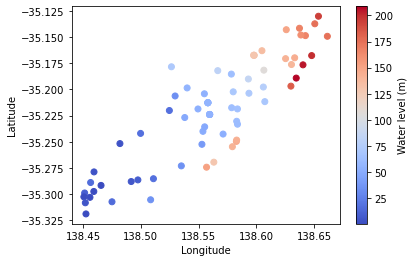

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111)

s = ax.scatter(df.decimal_long, df.neg_decimal_lat, c=df.rswl, cmap="coolwarm")
cb = plt.colorbar(s)
cb.set_label('Water level (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

## Change format of df with water level data 

To make it more useable for this script

In [220]:
df.head()

df.columns

Index(['DHNO', 'DHNO.1', 'Unit_No', 'Unit_Number', 'dh_name', 'network',
       'Obs_No', 'drillhole_class', 'water_point_type_code', 'Aquifer',
       'Orig_drilled_depth', 'Orig_drilled_date', 'max_drill_depth',
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam', 'purpose', 'latest_status',
       'latest_status_date', 'dtw', 'swl', 'rswl', 'water_level_date', 'TDS',
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
       'mga_easting', 'mga_northing', 'mga_zone', 'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'decimal_long', 'decimal_lat', 'neg_decimal_lat',
       'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime'],
      dtype='object')

In [222]:
df = df.drop(columns=['DHNO', 'DHNO.1', 'Unit_No', 'Unit_Number', 'dh_name', 'network',
       'Obs_No', 'drillhole_class', 'water_point_type_code', 'Aquifer',
       'Orig_drilled_depth', 'Orig_drilled_date', 'max_drill_depth',
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam', 'purpose', 'latest_status',
       'latest_status_date', 'dtw', 'swl', 'water_level_date', 'TDS',
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
       'mga_easting', 'mga_northing', 'mga_zone', 'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'decimal_lat', 'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime'])

In [221]:
df_utm = df.drop(columns=['DHNO', 'DHNO.1', 'Unit_No', 'Unit_Number', 'dh_name', 'network',
       'Obs_No', 'drillhole_class', 'water_point_type_code', 'Aquifer',
       'Orig_drilled_depth', 'Orig_drilled_date', 'max_drill_depth',
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam', 'purpose', 'latest_status',
       'latest_status_date', 'dtw', 'swl', 'water_level_date', 'TDS',
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
       'mga_zone', 'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'decimal_lat', 'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime'])

In [223]:
df = df.rename(columns={'rswl':'Z', 'decimal_long':'X', 'neg_decimal_lat':'Y'})
df.head()

,Z,X,Y
0,4.09,138.459534,-35.278757
1,4.33,138.481972,-35.251705
2,18.22,138.499847,-35.241988
3,5.54,138.491737,-35.287951
4,15.90,138.475098,-35.307286


In [224]:
df_utm = df_utm.rename(columns={'rswl':'Z', 'mga_easting':'X', 'mga_northing':'Y'})
df_utm.head()

,Z,X,Y,decimal_long,neg_decimal_lat
0,4.09,268941.81,6093083.52,138.459534,-35.278757
1,4.33,270906.82,6096136.56,138.481972,-35.251705
2,18.22,272506.29,6097255.78,138.499847,-35.241988
3,5.54,271897.13,6092138.11,138.491737,-35.287951
4,15.90,270438.32,6089954.64,138.475098,-35.307286


## Load the Willunga regular grid

This is what I want to interpolate onto

I made it in this script: http://localhost:8889/notebooks/willunga_wt_kriging.ipynb 

<AxesSubplot:>

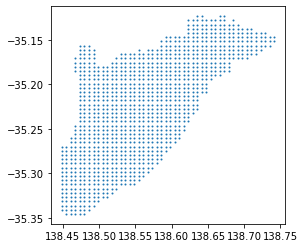

In [225]:

grid_file = os.path.join(outputdatapath,
                               "willunga_regular_grid.shp")

willunga_grid = gpd.read_file(grid_file)

willunga_grid.plot(markersize=1)

## Create a variogram map for the Willunga data

First, define the parameters to use

In [227]:
lagdist = 1000 
nlagx = 7 
nlagy= 7
minpairs=5
vmax=1.2
bstand=1

In [228]:
help(varmapv_2d)

Help on function varmapv_2d in module __main__:

varmapv_2d(df, xcol, ycol, vcol, nx, ny, lagdist, minpairs, vmax, bstand, title, vlabel)
    # irregular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)



In [229]:
df['Z']

0       4.09
1       4.33
2      18.22
3       5.54
4      15.90
       ...  
68    129.42
69    184.26
70    131.49
71    131.85
72    128.99
Name: Z, Length: 73, dtype: float64

### To try and find out where I am going wrong, I am going to slowly convert their dataframe to mine

In [230]:
rand_df = rand_sample.copy()
len(rand_df)

rows_to_drop = list(range(73,100))
# Make the same length as mind
rand_df = rand_df.drop(rows_to_drop, axis=0)
print(len(rand_df))
print(len(df))

rand_df.head()

73
73


,X,Y,Porosity
0,50.0,549.0,0.10636
1,240.0,679.0,1.60953
2,530.0,539.0,0.93673
3,370.0,369.0,0.31166
4,610.0,649.0,-0.85149


In [204]:
rand_df['Y'] = df['Y']
rand_df['X'] = df['X']
rand_df['Porosity'] = df['Z']
rand_df.head()


,X,Y,Porosity
0,138.459534,-35.278757,4.09
1,138.481972,-35.251705,4.33
2,138.499847,-35.241988,18.22
3,138.491737,-35.287951,5.54
4,138.475098,-35.307286,15.90


Text(56.60283422097024, 0.5, 'Latitude')

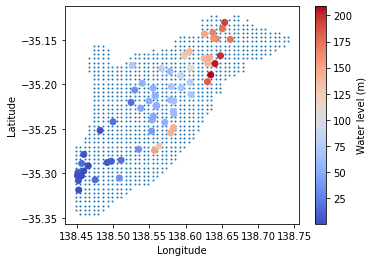

In [205]:
fig = plt.figure()
ax = fig.add_subplot(111)

willunga_grid.plot(markersize=1, ax=ax)
s = ax.scatter(rand_df.X, rand_df.Y, c=rand_df.Porosity, cmap="coolwarm")
cb = plt.colorbar(s)
cb.set_label('Water level (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")



## I am going to convert from lat long to x y values because maybe this is what is stuffing everything up

In [206]:
rand_df_xy = rand_df.copy()
rand_df_save = rand_df.copy() # so that I can just usethe rand_df as the name for the df I use since it's all set up

In [207]:
rand_df_xy["Xx"] = (rand_df["X"]*100)-13800
#print(rand_df_xy["Xx"])
print(rand_df_xy["Xx"].describe())

count    73.000000
mean     56.120449
std       5.801817
min      45.076220
25%      52.974120
50%      55.961820
75%      59.816120
max      66.151820
Name: Xx, dtype: float64


In [208]:
rand_df_xy["Yy"] = (rand_df["Y"]*100)+3600
#print(rand_df_xy["Yy"])
print(rand_df_xy["Yy"].describe())

count    73.000000
mean     77.816213
std       4.942405
min      68.112450
25%      74.759440
50%      78.138350
75%      81.794150
max      86.989050
Name: Yy, dtype: float64


Text(0, 0.5, 'Latitude')

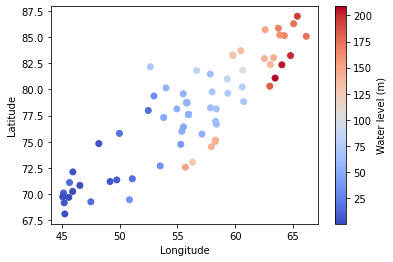

In [209]:
fig = plt.figure()
ax = fig.add_subplot(111)

#willunga_grid.plot(markersize=1, ax=ax)
s = ax.scatter(rand_df_xy.Xx, rand_df_xy.Yy, c=rand_df.Porosity, cmap="coolwarm")
cb = plt.colorbar(s)
cb.set_label('Water level (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [210]:
type(rand_df_xy)

pandas.core.frame.DataFrame

## For just a test I am going change my x and y measurements and see if the variogram map changes

In [128]:
rand_df1 = rand_df_xy.copy()
rand_df1 = rand_df_xy.sort_values(by=['Yy'])

In [129]:
i=0
print(rand_df1.index[i])
print(rand_df1.loc[i, "X"])
add = np.linspace(-40, 40, 81)

print(rand_df1.loc[i, "X"] + add[i])

11
138.4595342
98.45953420000001


In [130]:
print(add)
new_x = []

[-40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28. -27.
 -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13.
 -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.]


In [131]:
for i in range(len(rand_df1)):
    #print(i)
    new_x.append(rand_df1.loc[i, "X"] + add[i])
    rand_df1.loc[i, "Y"] = rand_df1.loc[i, "Y"] + add[i]
    #rand_df1.loc[i, "Y"] = rand_df1.loc[i, "Y"] + add[i]

print(new_x)  

[98.45953420000001, 99.48197219999997, 100.49984719999998, 101.491737, 102.47509819999999, 103.46562119999999, 104.45143920000001, 105.45076219999999, 106.45202419999998, 107.4560372, 108.45937119999999, 109.4525712, 110.4566002, 111.50853620000001, 112.55694319999998, 113.5793112, 114.57125919999999, 115.52974119999999, 116.58002919999998, 117.60654819999999, 118.66151819999999, 119.64254419999997, 120.6479262, 121.54013710000001, 122.52655019999997, 123.56664419999998, 124.6259532, 125.65380919999998, 126.65064019999997, 127.53807519999998, 128.6304602, 129.54951819999997, 130.5529504, 131.57842119999998, 132.57867119999997, 133.5936342, 134.5830202, 135.5837292, 136.5538202, 137.6073802, 138.55531919999999, 139.63322419999997, 140.6061082, 141.58370119999998, 142.62535119999998, 143.5931412, 144.63859219999998, 145.5247662, 146.51097819999998, 147.60489819999998, 148.63737460000002, 149.58274719999997, 150.6345692, 151.5581312, 152.5596172, 153.5580982, 154.5580982, 155.5580982, 156

Text(0, 0.5, 'Latitude')

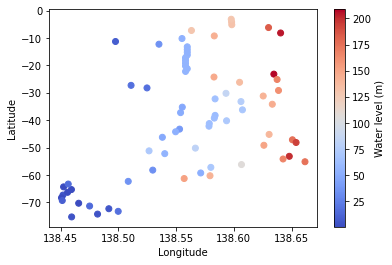

In [132]:
fig = plt.figure()
ax = fig.add_subplot(111)

#willunga_grid.plot(markersize=1, ax=ax)
s = ax.scatter(rand_df1.X, rand_df1.Y, c=rand_df1.Porosity, cmap="coolwarm")
cb = plt.colorbar(s)
cb.set_label('Water level (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")




In [231]:
df_utm.head()

,Z,X,Y,decimal_long,neg_decimal_lat
0,4.09,268941.81,6093083.52,138.459534,-35.278757
1,4.33,270906.82,6096136.56,138.481972,-35.251705
2,18.22,272506.29,6097255.78,138.499847,-35.241988
3,5.54,271897.13,6092138.11,138.491737,-35.287951
4,15.90,270438.32,6089954.64,138.475098,-35.307286


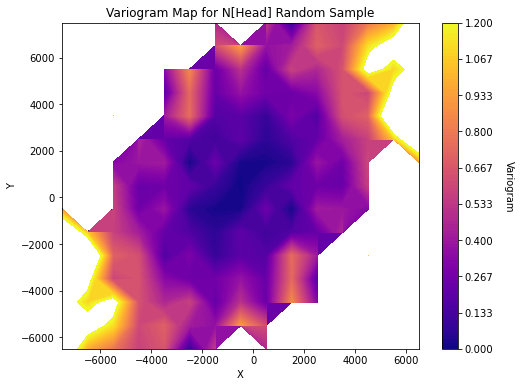

In [232]:
varmap_irregular = varmapv_2d(df_utm,'X','Y','Z',nlagx, nlagy, lagdist,
                              minpairs,
                              vmax,
                              bstand,'Variogram Map for N[Head] Random Sample','Variogram')

### For some reason my X column has to be called porosity, it isn't working if I change the name!! 

I think I have fixed this - in the fuction above he used his dataframe title for the name (not just df which as set up in the function description)

varmapv_2d(df,xcol,ycol,vcol,nx,ny,lagdist,minpairs,vmax,bstand,title,vlabel)

nx and ny are parameters but they haven't been defined 

In [133]:
print(rand_df.columns)
nlagx = 3#7
print("nlagx: %s" %nlagx)
nlagy = 2 #7
print("nlagy: %s" %nlagy)
lagdist = 30#3
print("lag distance: %s" %lagdist)
minpairs = 1#5
print("min pairs: %s" %minpairs)
vmax = 2200#1.2
print("vmax: %s" %vmax)
bstand = 0#0
print(bstand)
nx = len(rand_df) #100
print("nx: %s" %nx)
ny = nx
print("ny: %s" %ny)

Index(['X', 'Y', 'Porosity'], dtype='object')
nlagx: 3
nlagy: 2
lag distance: 30
min pairs: 1
vmax: 2200
0
nx: 73
ny: 73


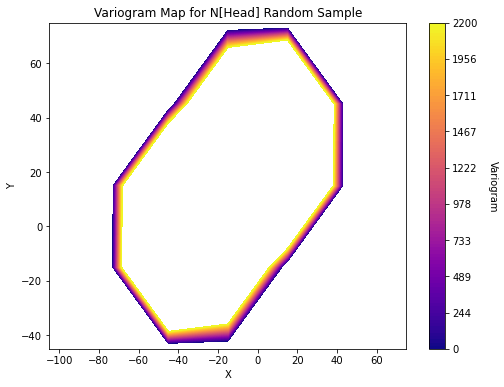

In [134]:
varmap_irregular = varmapv_2d(rand_df_xy,'Xx','Yy','Porosity',nlagx, nlagy, lagdist,
                              minpairs,
                              vmax,
                              bstand,'Variogram Map for N[Head] Random Sample','Variogram')

gamv_2d(df,xcol,ycol,vcol,nlag,lagdist,azi,atol,bstand)

In [170]:
nlag = 10; lag = 5; azi = 90; atol = 90; standardize = 1#0        # set the variogram calculation parameters
# calculate the isotropic variogram
lag_iso,gamma_iso,npair_iso = gamv_2d(rand_df_xy,'Xx','Yy','Porosity',nlag,lag,azi,atol,standardize)  

### Let's visualise this variogram

In [148]:
help(vargplt)

Help on function vargplt in module __main__:

vargplt(lag, gamma, npair, vtype, name, xmin, xmax, ymin, ymax, sill, title, cmap)



C:\Users\mar886\Anaconda3\envs\geostats_env\lib\site-packages\ipykernel_launcher.py:128: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.


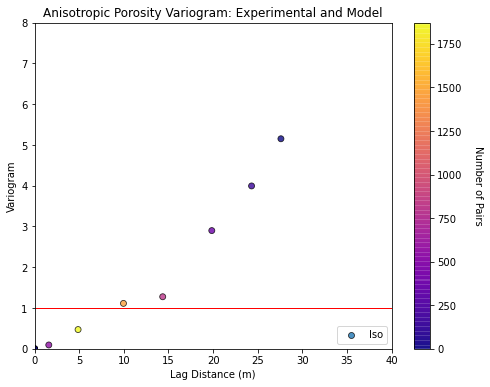

In [156]:
vtype_iso = 0
name_iso = 'Iso'
vargplt(lag_iso,gamma_iso,npair_iso,vtype_iso,name_iso,0,40,0,8,1,
        "Anisotropic Porosity Variogram: Experimental and Model",cmap)


The isotropic variogram is quite well behaved. Let's try to calculate directional variograms. We know the major direction should be 090 azimuth, along the X axis.



In [174]:
azi = 45; atol = 45; standardize = 1#0        # set the variogram parameters
# calculate the isotropic variogram
lag_000,gamma_000,npair_000 = gamv_2d(rand_df_xy,'Xx','Yy','Porosity',nlag,lag,azi,atol,standardize)  
azi = 135; atol = 45; standardize = 1#0        # set the variogram parameters
# calculate the isotropic variogram
lag_090,gamma_090,npair_090 = gamv_2d(rand_df_xy,'Xx','Yy','Porosity',nlag,lag,azi,atol,standardize) 

In [ ]:
rand_df.head()

Now let's visualize the 090 and 000 azimuth variograms. We need to once again put the arrays into lists to send to vargplt.



In [164]:
help(vargplts)

Help on function vargplts in module __main__:

vargplts(lag, gamma, npair, vtype, name, xmin, xmax, ymin, ymax, sill, title, cmap)



C:\Users\mar886\Anaconda3\envs\geostats_env\lib\site-packages\ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.


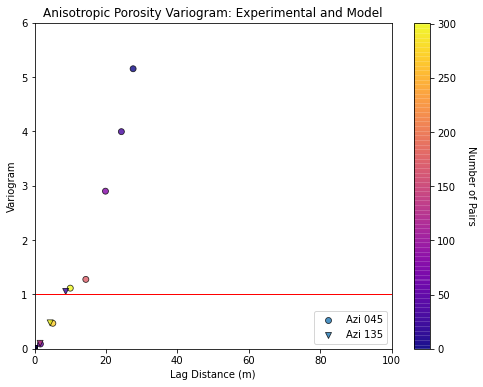

In [180]:
lags = np.array([lag_000,lag_090])
gammas = np.array([gamma_000,gamma_090])
npairs = np.array([npair_000,npair_090])
vtypes = [0,0]
names = ['Azi 045','Azi 135']
vargplts(lags,gammas,npairs,vtypes,names,0,100,0,6,1,"Anisotropic Porosity Variogram: Experimental and Model",cmap)

Now we can fit an anisotropic spatial continuity model,



In [182]:
azi = 45; rmaj = 400; rmin = 250

lag_000_mod,gamma_000_mod = vmodel_2d(nlag=7,azi=45,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=azi,rmaj1=rmaj,rmin1=rmin)


and visualize the resulting anisotropic variogram model with the experiemental variogram points.



C:\Users\mar886\Anaconda3\envs\geostats_env\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
C:\Users\mar886\Anaconda3\envs\geostats_env\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
C:\Users\mar886\Anaconda3\envs\geostats_env\lib\site-packages\ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any pa

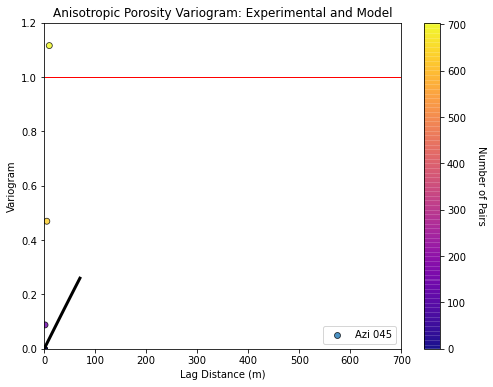

In [183]:
lags = np.array([lag_000,lag_000_mod])
gammas = np.array([gamma_000,gamma_000_mod])
npairs = np.array([npair_000])
vtypes = [0,1]
names = ['Azi 045','Azi 000']
vargplts(lags,gammas,npairs,vtypes,names,0,700,0,1.2,1,"Anisotropic Porosity Variogram: Experimental and Model",cmap)

## UP TO HERE - above is my data, in the name 'rand_df'!

### BELOW THIS IS JUST A COPY FROM GEOSTATSGUY SCRIPT

In [ ]:
varmap_irregular = varmapv_2d(df,
                              'X','Y','Z',
                              nlagx,nlagy,lagdist,
                              minpairs,vmax,bstand,
                              'Variogram Map for Head',
                              'Variogram')

## Data quality control and preprocessing

In [ ]:
hist(sim.flatten(),vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Dataset")
hist(nscore_sim.flatten(),-3,+3,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Nscore Transformed")
ex_mean = np.average(sim)
ex_var = np.var(sim)
ex_nscore_mean = np.average(nscore_sim)
ex_nscore_var = np.var(nscore_sim)
print('Exhastive Mean = ',round(ex_mean,2),', Exhaustive Variance = ',round(ex_var,2))
print('Exhastive Nscore Mean = ',round(ex_nscore_mean,2),', Exhaustive Nscore Variance = ',round(ex_nscore_var,2))


In [ ]:
pixelplt(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Porosity Realization","X(m)","Y(m)","Porosity (%)",cmap)
pixelplt(nscore_sim,xmin,xmax,ymin,ymax,cell_size,-3,+3,"NScore Porosity Realization","X(m)","Y(m)","N[Porosity]",cmap)

## Directions of continuity

In [ ]:
nlagx = 50; nlagy = 50; minpairs = 5;vmax = 1.2;bstand = 1
varmap_regular = varmap_2d(nscore_sim,nx,ny,cell_size,nlagx,nlagy,minpairs,vmax,bstand,'Variogram Map for N[Porosity] Model','Variogram')

## Irregularly sampled data variogram 

Note that I skipped the part on regularly sampled data

In [ ]:
rand_sample = random_sample(nscore_sim,xmin,xmax,ymin,ymax,cell_size,100,"Porosity")

In [ ]:
locpix(nscore_sim,0,1000,ymin,ymax,cell_size,-3,3,rand_sample,'X','Y','Porosity','Porosity Realization and Regular Samples','X(m)','Y(m)','Porosity (%)',cmap)


In [ ]:
locmap(rand_sample,'X','Y','Porosity',xmin,xmax,ymin,ymax,-3,3,'Porosity Samples','X(m)','Y(m)','Porosity (%)',cmap)


In [ ]:
nlag = 70; lag = 50; azi = 90; atol = 90; standardize = 0        # set the variogram calculation parameters
# calculate the isotropic variogram
lag_iso,gamma_iso,npair_iso = gamv_2d(rand_sample,'X','Y','Porosity',nlag,lag,azi,atol,standardize)  

In [ ]:
vtype_iso = 0
name_iso = 'Iso'
vargplt(lag_iso,gamma_iso,npair_iso,vtype_iso,name_iso,0,1000,0,1.5,1,"Anisotropic Porosity Variogram: Experimental and Model",cmap)

## THERE IS MORE CODE BELOW - CALCULATE DIRECTIONALITY

But now let's see if I can get up to here with my own data

## Make a 2D spatial model

In [226]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 74074                                                     # random number seed  for stochastic simulation    
range_max = 500; range_min = 200; azimuth = 90                   # Porosity variogram ranges and azimuth
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

In [196]:
# calculate a stochastic realization with standard normal distribution
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,range_max,range_min,azimuth,"simulation")

In [197]:
sim = affine(sim,mean,stdev)                                     # correct the distributi

In [198]:
nscore_sim = nscore(sim)

In [199]:
## Can delete this cell later

rand_sample = random_sample(nscore_sim,xmin,xmax,ymin,ymax,cell_size,100,"Porosity")

print(type(rand_sample))
rand_sample.head()

<class 'pandas.core.frame.DataFrame'>


,X,Y,Porosity
0,50.0,549.0,0.10636
1,240.0,679.0,1.60953
2,530.0,539.0,0.93673
3,370.0,369.0,0.31166
4,610.0,649.0,-0.85149
